# Machine Learning with the Google Earth Engine Python API

### Motivation
Using Google Earth Engine (GEE) through the python API (as opposed to the JS API) provides users with greater flexibility and easier access to python, R and Julia functionality if used through project Jupyter (reccommended).

In the upcoming notebooks, users will be taken through getting started with GEE Machine Learning (ML) in python for Earth Observation (EO) based ecological applications.

### Pre-requisites

* A Google Earth Engine (GEE) Account
* At least 2 MB of Google Drive Space for the same email address used to register for GEE.
* A basic grasp of coding concepts (variables, functions, for loops and if statements).

## Part 1: Introduction

After going through this notebook, you will know:

    1. The reccommended tools for using the GEE Python API.
    2. How to perform a standard supervised classification in GEE including data preparation, Model training, Model evaluation and Inference.
    3. How to perform basic hyperparameter tuning.
    4. Compute the area of output classification maps.
    5. Download the classified map to disk.

### 1. The tools

##### GEE Python API: SWOT Analysis

**Strengths**

* GEE has limited ML functionality whereas python is very popular for machine learning development. Therefore, by
    using the GEE python API, once can leverage the most recent ML developments in a single end-to-end workflow.
* Supports the creation of publication-quality maps.
* If using python through project jupyter, the seamless use of R and python in a single notebook is possible.
* In some cases, faster and direct data extraction via the high volume endpoint to a local drive compared to slower and multi-step (Export to Google drive, then download locally) downloads with the JS API.

**Weaknesses**

* Steeper learning curve
* Maintaining a local python environment for spatial analyses can be troublesome.
* A lot of the intial benefits of the JS API over the Python API has been overcome by community developers. Indivduals may stop maintaining code.
* Third party software may not be of the highest standard (For example, poor documentation).

**Opportunities**

* Spatially explicit and large scale analyses
* Combining the benefits from Python and R (when using Jupyter)

**Threats**

* Owing to the ease of use of different datasets, there is a greater risk of data misuse, without adequate consideration for data limitations.
* Earth Engine is not open source and there are risks of Google no longer providing free access to researchers and NGO's, or implementing more stringent usuage quotas or may shutdown the platform.

For these tutorials, I suggest using Google collaboratory because it is far easier to setup in comparison to a local jupyter notebook. However, if you plan on using python for GEE in the long term, setting up Anaconda with jupyter lab and a virtual environment (locally) is strongly recommended. Refer to additional resources for steps to setup a local python environment.

In these tutorials, we will use:

   * Google colab - A freely available cloud hosted jupyter notebook
   * geemap - A python package that makes the use of GEE in python easier
   * geeml - A python package that makes the extraction of GEE data easier and faster to download directly to your drive.

## Install packages

Since we are using Google colab we can skip the setup of a virtual environment and proceed by installing additional packages not  available by default in the Google Colab environment. Once complete, restart the runtime.  

watermark is a useful package to print out the python version and loaded package versions

In [1]:
# Install packages not available in colab
%pip install watermark -q 


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import packages

In [1]:
# Load watermark package
%load_ext watermark

In [2]:
# Import and initialize Google Earth Engine. When running this cell in colab, you will always be prompted to authenticate first.
import ee
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

# Import geemap - a package that includes lots of utility fucntions to make working with GEE in python easier     
import geemap
import geemap.colormaps as cm

# Matplotlib is the de facto visualisation package in python
import matplotlib.pyplot as plt

In [3]:
# Prints the python version and the imported package versions
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

geemap    : 0.17.1
ee        : 0.2
matplotlib: 3.5.2



## Initialise an interactive map

A geemap Map object provides an interactive map that allows users to explore GEE data within a jupyter notebook. This Map object also has numerous additional builtin functionality that allows users to:  
1. Search the earth engine catalog  
2. Change the basemap  
3. Draw areas on the map that are then accessible via the EE API  
4. Load locally stored vector and raster data  
5. Inspect/query the layers that are shown  

Once you run the code cell below, hover over the widgets on the top left and right. The globe widget on the top left, allows users to search for earth engine datasets or places using their names or latitudes and longitudes. The tool widget on the top right has a lot more functionality which you can find out more about in the key features section [here](https://geemap.org/).

In [4]:
# Create an interactive map
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## 01. Basic supervised classification

We will learn how to do a basic land cover classification using training samples collected from the Code Editor using the High Resolution basemap imagery provided by Google Maps. This method is quite effective to generate high quality classification samples anywhere in the world.

The goal is to classify each source pixel into one of the following classes:

- Urban
- Bare
- Water
- Vegetation

Specifically, using the drawing tools in the map,  4 new feature collections with points representing pixels of that class were created. Each feature collection has a property called landcover with values of 0, 1, 2 or 3 indicating whether the feature collection represents urban, bare, water or vegetation respectively.

We then train a Random Forest classifier using this training set to build a model and apply it to all the pixels of the image to create a 4 class image.

In [5]:
# Load Bangolore boundary
bangalore = ee.FeatureCollection("users/ujavalgandhi/public/bangalore_boundary")
# Load Sentinel-2 atmospherically corrected data
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")

# The following collections were created using the 
# Drawing Tools in the code editor 
urban = ee.FeatureCollection("users/ujavalgandhi/e2e/urban_gcps")
bare = ee.FeatureCollection("users/ujavalgandhi/e2e/bare_gcps")
water = ee.FeatureCollection("users/ujavalgandhi/e2e/water_gcps")
vegetation = ee.FeatureCollection("users/ujavalgandhi/e2e/vegetation_gcps")

# Filter Sentinel-2 data
# Select images with less than 30% cloud cover
# Select images for 2019. end-date is exclusive
# Select images that overlap the bangalore boundary
# Select all bands starting with the letter 'B'
filtered = s2\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
    .filter(ee.Filter.date('2019-01-01', '2020-01-01'))\
    .filter(ee.Filter.geometry(bangalore))\
    .select('B.*')

# Using all remaining images after filtering, compute the median and clip to the boundary of the bangalore boundary
composite = filtered.median().clip(bangalore) 

# Define the visualisation parameters to display the input composite.
rgbVis = {
  "min": 0.0,
  "max": 3000,
  "bands": ['B4', 'B3', 'B2'],
}

Map.centerObject(urban.first(), 9)# Center the map on the composite geometry
Map.addLayer(composite, rgbVis, "image")# Visualise the Sentinel-2 composite
# Plot the locations of the reference points
Map.addLayer(urban, {}, "urban")
Map.addLayer(bare, {}, "bare")
Map.addLayer(water, {}, "water")
Map.addLayer(vegetation, {}, "vegetation")
Map

Map(center=[12.954774480921643, 77.65618319730623], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
# Combine the feature collections
gcps = urban.merge(bare).merge(water).merge(vegetation)

# Overlay the point on the image to get training data.
training = composite.sampleRegions(**{
  "collection": gcps,
  "properties": ['landcover'], 
  "scale": 10
})


# Train a classifier.
classifier = ee.Classifier.smileRandomForest(numberOfTrees = 50, seed = 42).train(**{
  "features": training,  
  "classProperty": 'landcover', 
  "inputProperties": composite.bandNames()
})

# Classify the image.
classified = composite.classify(classifier)
# Visualise the classified image
Map.addLayer(classified, {"min": 0, "max": 3, "palette": ["gray", "brown", "blue", "green"]}, "2019")

In [7]:
# Display the collected points
# We use the style() function to style the reference points
palette = ee.List(['gray','brown','blue','green'])
landcover = ee.List([0, 1, 2, 3])

def fun(lc):
    color = palette.get(landcover.indexOf(lc))
    markerStyle = {"color": "white", "pointShape": "diamond", "pointSize": 4, "width": 1, "fillColor": color}
    return gcps.filter(ee.Filter.eq("landcover", lc)).map(lambda point: point.set("style", markerStyle))

gcpsStyled = ee.FeatureCollection(landcover.map(lambda lc: fun(lc))).flatten()
      
Map.addLayer(gcpsStyled.style(**{"styleProperty":"style"}), {}, 'GCPs')

## 02. Accuracy Assessment

It is important to get a quantitative estimate of the accuracy of the classification. To do this, a common strategy is to divide your training samples into 2 random fractions: one used for training the model and the other for validation of the predictions.

Once a classifier is trained, it can be used to classify the entire image. We can then compare the classified values with the ones in the validation fraction. We can use the ee.Classifier.confusionMatrix() method to calculate a Confusion Matrix representing expected accuracy.

Don't get carried away tweaking your model to give you the highest validation accuracy. You must use both qualitative measures (such as visual inspection of results) along with quantitative measures to assess the results.

In [8]:
# Load Sentinel-2, Filter, compute median and clip to area of interest (a basin within bangolore)
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
basin = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_7")
gcp = ee.FeatureCollection("users/ujavalgandhi/e2e/arkavathy_gcps")
    
arkavathy = basin.filter(ee.Filter.eq('HYBAS_ID', 4071139640))
boundary = arkavathy.geometry()
rgbVis = {
  "min": 0.0,
  "max": 3000,
  "bands": ['B4', 'B3', 'B2'],
}
 
filtered = s2\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
    .filter(ee.Filter.date('2019-01-01', '2020-01-01'))\
    .filter(ee.Filter.geometry(boundary))\
    .select('B.*')

composite = filtered.median().clip(boundary) 

# Display the input composite.
Map.addLayer(composite, rgbVis, 'image');

In [9]:
# Add a random column and split the GCPs into training and validation set
gcp = gcp.randomColumn(seed = 42)

# This being a simpler classification, we take 60% points
# for validation. A more popuular ratio is
# 70% training, 30% validation
trainingGcp = gcp.filter(ee.Filter.lt('random', 0.6))
validationGcp = gcp.filter(ee.Filter.gte('random', 0.6))

# Extract the image values at the point locations to get training data.
training = composite.sampleRegions(**{
  "collection": trainingGcp,
  "properties": ['landcover'],
  "scale": 10,
  "tileScale": 16
})

# Train a classifier.
classifier = ee.Classifier.smileRandomForest(numberOfTrees = 50, seed = 42)\
    .train(**{
        "features": training,  
        "classProperty": 'landcover',
        "inputProperties": composite.bandNames()
})

# Classify the image
classified = composite.classify(classifier)

Map.addLayer(classified, {"min": 0, "max": 3, "palette": ["gray", "brown", "blue", "green"]}, "2019")

## Accuracy Assessment

In [10]:
# Use the classification map and the validation points to estimate the models accuracy.
test = classified.sampleRegions(**{
  "collection": validationGcp,
  "properties": ['landcover'],
  "tileScale": 16,
  "scale": 10,
})

# Compute a confusion matrix
testConfusionMatrix = test.errorMatrix('landcover', 'classification')

# Printing of confusion matrix may time out. Alternatively, you can export it as CSV
print('Confusion Matrix', testConfusionMatrix.getInfo())
print('Test Accuracy', testConfusionMatrix.accuracy().getInfo())

Confusion Matrix [[39, 1, 0, 0], [4, 36, 0, 0], [0, 0, 36, 4], [0, 0, 1, 41]]
Test Accuracy 0.9382716049382716


## 03. Improving the Classification

The Earth Engine data-model is especially well suited for ML tasks because of its ability to easily incorporate data sources of different spatial resolutions, projections and data types together By giving additional information to the classifier, it is able to separate different classes easily.

Here we take the same example and augment it with different spectral indices such as - NDVI, NDBI, MNDWI and BSI. We also add slope and elevation bands from the ALOS DEM.

The result is a much improve the classification.

In [11]:
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
basin = ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_7")
gcp = ee.FeatureCollection("users/ujavalgandhi/e2e/arkavathy_gcps")
alos = ee.Image("JAXA/ALOS/AW3D30/V2_2")

arkavathy = basin.filter(ee.Filter.eq('HYBAS_ID', 4071139640))
boundary = arkavathy.geometry()
rgbVis = {
  "min": 0.0,
  "max": 3000,
  "bands": ['B4', 'B3', 'B2'],
}

def maskCloudAndShadowsSR(img):
    """Removes cloud and snow pixels from Sentinel-2 SR image."""
    cloudProb = img.select('MSK_CLDPRB')
    snowProb = img.select('MSK_SNWPRB')
    cloud = cloudProb.lt(10)
    scl = img.select('SCL') 
    shadow = scl.eq(3)
    cirrus = scl.eq(10)
    
    # Cloud probability less than 10% or cloud shadow classification
    mask = cloud.And(cirrus.neq(1)).And(shadow.neq(1))
    return img.updateMask(mask).divide(10000)


filtered = s2\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))\
    .filter(ee.Filter.date('2019-01-01', '2019-12-31'))\
    .filter(ee.Filter.geometry(boundary))\
    .map(maskCloudAndShadowsSR)\
    .select('B.*')

composite = filtered.median().clip(boundary) 

def addIndices(img):
    ndvi = img.normalizedDifference(['B8', 'B4']).rename(['ndvi'])# Vegetation index
    ndbi = img.normalizedDifference(['B11', 'B8']).rename(['ndbi'])# Built-up index
    mndwi = img.normalizedDifference(['B3', 'B11']).rename(['mndwi'])# Modified water index
    bsi = img.expression( #Bare soil inedex
      "(( X + Y ) - (A + B)) /(( X + Y ) + (A + B))", {
        "X": img.select("B11"),
        "Y": img.select("B4"),
        "A": img.select("B8"),
        "B": img.select("B2")
      }).rename("bsi")
    return img.addBands(ndvi).addBands(ndbi).addBands(mndwi).addBands(bsi)

composite = addIndices(composite)

elev = alos.select('AVE_DSM').divide(2000).rename('elev')
slope = ee.Terrain.slope(alos.select('AVE_DSM')).divide(30).rename('slope')

composite = composite.addBands([elev, slope])

visParams = {"bands": ['B4', 'B3', 'B2'], "min": 0, "max": 0.3, "gamma": 1.2}
Map.addLayer(composite, visParams, 'RGB')

In [12]:
# Add a random column and split the GCPs into training and validation set
gcp = gcp.randomColumn(seed = 42)

# This being a simpler classification, we take 60% points
# for validation. Normal recommended ratio is
# 70% training, 30% validation
trainingGcp = gcp.filter(ee.Filter.lt('random', 0.6))
validationGcp = gcp.filter(ee.Filter.gte('random', 0.6))

# Overlay the point on the image to get training data.
training = composite.sampleRegions(**{
  "collection": trainingGcp,
  "properties": ['landcover'],
  "scale": 10,
  "tileScale": 16
})

# print the points for inspection
training

In [13]:
# Train a classifier.
classifier = ee.Classifier.smileRandomForest(numberOfTrees = 50, seed = 42)\
    .train(**{
        "features": training,  
        "classProperty": 'landcover',
        "inputProperties": composite.bandNames()
    })

# Classify the image.
classified = composite.classify(classifier)

Map.addLayer(classified, {"min": 0, "max": 3, "palette": ['gray', 'brown', 'blue', 'green']}, '2019')

## Accuracy Assessment

In [14]:
# Use classification map to assess accuracy using the validation fraction
# of the overall training set created above.
test = classified.sampleRegions(**{
  "collection": validationGcp,
  "properties": ['landcover'],
  "scale": 10,
  "tileScale": 16
})

testConfusionMatrix = test.errorMatrix("landcover", "classification")

# Printing of confusion matrix may time out. Alternatively, you can export it as CSV
print('Confusion Matrix:', testConfusionMatrix.getInfo())
print('Test Accuracy:', testConfusionMatrix.accuracy().getInfo())

Confusion Matrix [[38, 1, 0, 0], [5, 35, 0, 0], [0, 0, 36, 4], [0, 0, 1, 41]]
Test Accuracy 0.9316770186335404


In [15]:
# Run .explain() to see what the classifer looks like
classifier.explain()

The addition of indices, elevation and the slope variable have slightly reduced the accuracy (93.8% vs 93.2%). Typically, the addition of covariates improves the accuracy, however, in this case it was not the outcome. When I used the default seed, there was a increase.

**Takeaway:** If you are presenting results in a research paper, it is therefore recommended that the mean(standard deviation) scores are reported across multiple randomly selected seeds.

## 04. Hyperparameter Tuning
An additional way to improve a models accuracy is by modifying the hyperparameters of a model. So how do we determine what values to choose? The answer is hyperparameter tuning.

For example, when using the ee.Classifier.smileRandomForest() classifier, we must specify the Number of Trees. We know that higher number of trees result in more computation requirement, but it doesn't necessarily result in better results.

Instead of guessing, we programmatically try a range of values and choose the smallest value possible that results in the highest accuracy.

In [19]:
test = composite.sampleRegions(**{
  "collection": validationGcp,
  "properties": ['landcover'],
  "scale": 10,
  "tileScale": 16
})

# Tune the numberOfTrees parameter.
numTreesList = ee.List.sequence(10, 150, 10)

def calc_acc(trees):
    classifier = ee.Classifier.smileRandomForest(numberOfTrees = trees, seed = 42)\
        .train(**{
            "features": training,
            "classProperty": "landcover",
            "inputProperties": composite.bandNames()
    })
    
    # Here we are classifying a table instead of an image
    # ... Classifiers work on both images and tables
    return test.classify(classifier).errorMatrix('landcover', 'classification').accuracy()

accuracies = numTreesList.map(calc_acc)

In [20]:
x = numTreesList.getInfo()
y = accuracies.getInfo()

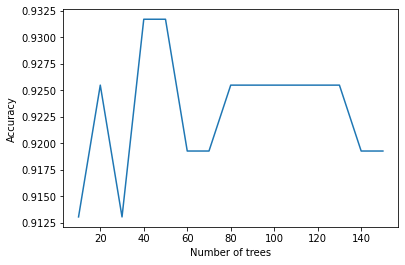

In [21]:
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("Number of trees")
ax.set_ylabel("Accuracy")
plt.show()

## 05. Exporting Classification Results
When working with complex classifiers over large regions, you may get a User memory limit exceeded or Computation timed out error in the Code Editor. The reason for this is that there is a fixed time limit and smaller memory allocated for code that is run with the On-Demand Computation mode.

For larger computations, you can use the Batch mode with the built-in GEE Export functions. Exports run in the background and can run longer than the 5-minute time allocated to the computation code run from the Code Editor. This allows you to process very large and complex datasets.

In addition, you may want to download the composite image locally or the classified image to use in a figure for publication. Here’s an example showing how to export your composite and classification results to your disk (in this case, Google Drive).

In [32]:
print('Overall accuracy:', testConfusionMatrix.accuracy().getInfo())

# Download composite image
geemap.download_ee_image(composite, "composite.tif", scale=100)

# Download classified image
geemap.download_ee_image(classified, "classified.tif", scale=100)

Overall accuracy: 0.9316770186335404
Generating URL ...
An error occurred while downloading.
Total request size (60598800 bytes) must be less than or equal to 50331648 bytes.


classified.tif: |                                                     | 0.00/48.5M (raw) [  0.0%] in 00:00 (et…

There is no STAC entry for: None


## 06. Calculating Area
Now that we have the results of our classification, we will learn how to calculate the area for pixels in each class. Calculating area for features is done using the area() function and for images using the ee.Image.pixelArea() function. The ee.Image.pixelArea() function creates an image where each pixel’s value is the area of the pixel.

We multiply this pixel area image with our image and sum up the area using the reduceRegion() function.

In [24]:
classified = ee.Image("users/ujavalgandhi/e2e/bangalore_classified")
bangalore = ee.FeatureCollection("users/ujavalgandhi/public/bangalore_boundary")
admin2 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

Map.addLayer(bangalore, {"color": "blue"}, "Bangalore City")
Map.addLayer(classified,
  {"min": 0, "max": 3, "palette": ["gray", "brown", "blue", "green"]},
  "Classified Image 2019")

In [26]:
# .area() function calculates the area in square meters
cityArea = bangalore.geometry().area()

# We can cast the result to a `ee.Number()` and calculate the
# area in square kilometers
cityAreaSqKm = ee.Number(cityArea).divide(1e6).round()
print('The area of Bangalore (sqkm):', cityAreaSqKm.getInfo())

The area of Bangalore (sqkm): 713


In [31]:
# Area Calculation for Images
vegetation = classified.eq(3)
# If the image contains values 0 or 1, we can calculate the
# total area using reduceRegion() function

# The result of .eq() operation is a binary image with pixels
# values of 1 where the condition matched and 0 where it didn't
Map.addLayer(vegetation, {"min": 0, "max": 1, palette: ['white', 'green']}, 'Green Cover')

# Since our image has only 0 and 1 pixel values, the vegetation
# pixels will have values equal to their area
areaImage = vegetation.multiply(ee.Image.pixelArea())

# Now that each pixel for vegetation class in the image has the value
# equal to its area, we can sum up all the values in the region
# to get the total green cover.
area = areaImage.reduceRegion(**{
    "reducer": ee.Reducer.sum(),
    "geometry": bangalore.geometry(),
    "scale": 10,
    "maxPixels": 1e10
})

# The result of the reduceRegion() function is a dictionary with the key
# being the band name. We can extract the area number and convert it to
# square kilometers
vegetationAreaSqKm = ee.Number(area.get('classification')).divide(1e6).round()
print('The area of vegetation in Bangolore (sqkm):', vegetationAreaSqKm.getInfo())

# Compute and print the percentage green cover of the city.
vegetationPercent = ee.Number(area.get('classification')).divide(1e6).divide(cityAreaSqKm).multiply(100).round()
print('The percentage of  Bangolore covered by vegetation (%):', vegetationPercent.getInfo())

The area of vegetation in Bangolore (sqkm): 122
The percentage of  Bangolore covered by vegetation (%): 17


### What are the benefits and drawbacks of this workflow?

#### Benefits 
- Easy to get started
- Rapid iteration

#### Drawbacks
- Flexibility
- Slow adoption of new techniques (it needs to be scalable)- there is an increasing collaboration between the community and the core GEE dev group. For example, More recent tabular models (XGBoost, LightGBM, NGBoost), Explainable AI and Deep learning.
- GEE API – free for research and NGOs only, does not natively support R

### What I (and other researchers) prefer to do in practice?
Try to maximise the benefits of GEE (compute and access to large amount and variety of data) for prototyping, baselines, rapid iteration and once these benefits are exhausted it makes sense to extract data and work with the data on your local machine or a cloud hosted R or Python environment.

In Part 2 (time permitting), we will replicate the basic land cover classification examples using such a workflow, where we extract the data and build a local model.

### Additional resources

- [Google Earth Engine book - Freely available](https://link.springer.com/book/10.1007/978-3-031-26588-4)
- [Qiusheng Wu's awesome GEE repo](https://gee-community-catalog.org/)

### Acknowledgements

- This tutorial relies heavily on the python ported version ([Found here](https://nbviewer.org/github/Akramz/end-to-end-gee/blob/main/4_Supervised_Classification_and_Change_Detection.ipynb)) of the supervised classification tutorial released by Ujaval 
 Gandhi in his publicly available end-end Gooogle Earth Engine Javascript course ([Found here](https://courses.spatialthoughts.com/end-to-end-gee.html)).

- I would like to thank Stellenbosch university for supporting the development of this material. 